<a href="https://colab.research.google.com/github/KOMBOU12/Marius/blob/main/MALIASH_2024_Repr%C3%A9sentation_vectorielle_du_sens_des_mots_(Sujet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Représentation vectorielle du sens des mots

**Auteur :** Adrien Guille (Université Lumière Lyon 2), pour le cours *Representation learning for NLP* @ Master 2 MALIA et Master 2 MIASH.

## Chargement des vecteurs

On télécharge une petite collection de vecteurs appris par la méthode **Skip-Gram avec échantillonnage négatif**.

Les représentations en dimension 300 des 100 000 mots les plus fréquents ont été apprises à partir de l'ensemble des pages francophones sur Wikipedia. Autrement dit, chacun des 100 000 mots les plus fréquents dans les articles Wikipedia sont associés à un vecteur $u \in \mathbb{R}^{300}$.

In [1]:
# Téléchargement
! wget https://raw.githubusercontent.com/AdrienGuille/adrienguille.github.io/main/assets/sgns.wiki.fr.zip
! unzip sgns.wiki.fr.zip

# Lecture du vocabulaire et des vecteurs
import pandas as pd
data = pd.read_csv("sgns.wiki.fr.vec", sep=" ", quoting=3, header=None, skiprows=1)
vocabulary = list(data[0].values)
vectors = data[range(1, 301)].values

# Définition d'une fonction pour accéder de façon sûre aux vecteurs
def get_vector(word):
  if word in vocabulary:
    return vectors[vocabulary.index(word)]
  else:
    return None

--2024-12-08 04:22:27--  https://raw.githubusercontent.com/AdrienGuille/adrienguille.github.io/main/assets/sgns.wiki.fr.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98204893 (94M) [application/zip]
Saving to: ‘sgns.wiki.fr.zip’

sgns.wiki.fr.zip    100%[===================>]  93.66M  61.9MB/s    in 1.5s    

2024-12-08 04:22:36 (61.9 MB/s) - ‘sgns.wiki.fr.zip’ saved [98204893/98204893]

Archive:  sgns.wiki.fr.zip
  inflating: sgns.wiki.fr.vec        


In [2]:
vocabulary.index('vice')

948

In [3]:
vectors[10].shape

(300,)

## Identification des mots proches

On mesure la proximité entre les mots comme une fonction du produit scalaire de leurs représentations. Plus exactement on mesure le produit scalaire normalisé par le produit des normes, qui correspond au cosinus de l'angle entre les deux vecteurs :
$$
\cos(\theta_{u_1, u_2}) = \frac{u_1 \cdot u_2}{||u_1|| \times ||u_2||}
$$

**Exercice** :
- Écrire la fonction `get_most_similar_words` qui reçoit une représentation vectorielle ou un mot et retourne les $n$ mots les plus proches.
- La tester !

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import heapq

# Fonction pour trouver les mots les plus similaires
def get_most_similar_words(vector, n=10):
    if isinstance(vector, str):
        # Si un mot est donné, récupère son vecteur
        vector = get_vector(vector)
        if vector is None:
            return f"Le mot '{vector}' n'existe pas dans le vocabulaire."

    # Liste pour stocker les similarités
    similarities = []

    # Calcul des similarités cosinus entre le vecteur donné et tous les vecteurs
    for i in range(len(vectors)):
        sim = cosine_similarity(vector.reshape(1, -1), vectors[i].reshape(1, -1))[0][0]
        similarities.append((sim, vocabulary[i]))

    # Trouver les n mots les plus proches (tri par similarité décroissante)
    most_similar = heapq.nlargest(n, similarities, key=lambda x: x[0])

    # Retourne les n mots avec leurs similarités
    return [(word, round(sim, 4)) for sim, word in most_similar]

# Tester la fonction
#print(get_most_similar_words("roi", n=5))
print(get_most_similar_words("chien", n=5))

[('chien', 1.0), ('chiens', 0.7498), ('chienne', 0.7083), ('chiot', 0.6648), ('chat', 0.663)]


## Visualisation des représentations et des relations entre elles: pays & capitales

**Exercice:**
- Extraire le sous-ensemble de vecteurs pour les mots donnés ci-après
- Les projeter linéairement en 3D au moyen d'une décomposition en valeurs singulières tronquée
- Visualiser les vecteurs dans le plan, d'après leurs coordonnées sur les 2ème et 3ème axes.

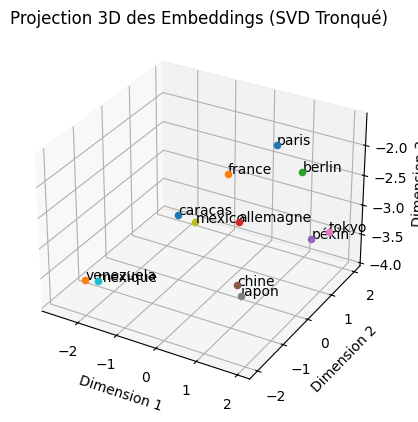

In [14]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

words = ['paris', 'france', 'berlin', 'allemagne', 'pékin', 'chine', 'tokyo', 'japon', 'mexico', 'mexique', 'caracas', 'venezuela']
word_vectors = [get_vector(w) for w in words]


# Réduction de dimension à 3 avec une SVD tronquée
svd = TruncatedSVD(n_components=3)
word_vectors_reduced = svd.fit_transform(np.array(word_vectors))

# Visualisation en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, word in enumerate(words):
    ax.scatter(word_vectors_reduced[i, 1], word_vectors_reduced[i, 2], word_vectors_reduced[i, 0], label=word)
    ax.text(word_vectors_reduced[i, 1], word_vectors_reduced[i, 2], word_vectors_reduced[i, 0], word, fontsize=10)


ax.set_title("Projection 3D des Embeddings (SVD Tronqué)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

## Prédiction du nom de la capitale à partir du nom d'un pays

**Exercice** :
- D'après le résultat obtenu précédemment, proposer une manière de deviner le nom de la capitale à partir du nom d'un pays d'après leurs représentations.
- Écrire la fonction `find_capital` qui implémente votre idée et la tester !

## Résolution d'analogies

On considère des analogies de la forme $a$ est à $b$, ce que $c$ est à $d$. Dans l'espace vectoriel on devrait avoir $u_a - u_b = u_c - u_d$.

**Exercice** :
- Écrire une fonction qui résoud une telle analogie, sachant $a$, $b$ et $c$.
- La tester !

In [ ]:
def solve_analogy(word_a, word_b, word_c):
